# Практична робота 8 — Регресія та Класифікація (TensorFlow/Keras)

Цей ноутбук — приклад повного виконання завдання з максимально детальними поясненнями.

- Тема: побудова нейронних мереж для задач регресії та класифікації.
- Інструменти: `scikit-learn` для генерації даних, `TensorFlow/Keras` для моделей, `matplotlib/seaborn` для візуалізації.
- Формат: покроково (дані → підготовка → модель → навчання → оцінка → висновки).

Варіант визначається "номером у журналі". У цьому прикладі використано номер: **7**. Ми явно і прозоро привʼяжемо параметри генерації даних та випадкові зерна до цього номера.


## 1. Параметри варіанта та інсталяції
У цьому блоці ми:
- задаємо номер студента;
- формуємо похідні параметри (зерна випадковості, невелике варіювання шуму/відокремленості класів тощо);
- за потреби — інсталюємо залежності (команда залишена закоментованою, щоб не запускатися автоматично).


In [1]:
# Якщо у середовищі бракує пакетів — зніміть коментар з наступного рядка.
# %pip install tensorflow scikit-learn matplotlib seaborn pandas

# Номер у журналі (варіант):
student_number = 7

# Всі випадковості привʼязуємо до номера — це забезпечує відтворюваність.
RANDOM_STATE = student_number

# Загальні параметри (незмінні між варіантами — для коректного порівняння результатів).
N_SAMPLES = 1000               # розмір вибірки і для регресії, і для класифікації
N_FEATURES = 5                 # кількість ознак (фіч)
TEST_SIZE = 0.2                # частка тестової вибірки

# Невелика варіація під варіант: шум у регресії та відокремленість класів у класифікації.
noise_reg = 10 + (student_number % 10)         # 10..19 — чим більший шум, тим складніше регресії
class_sep = 1.0 + 0.25 * (student_number % 5)  # 1.0..2.0 — більша відокремленість → легша класифікація

noise_reg, class_sep


(17, 1.5)

## 2. Імпорт бібліотек
Імпортуємо все необхідне для генерації даних, побудови моделей та аналізу якості.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
sns.set(style='whitegrid', context='notebook')


## 3. Регресія — підготовка даних
Генеруємо синтетичні дані для регресії за допомогою `make_regression`.
- Мета: навчити модель передбачати неперервне значення `y` за ознаками `X`.
- Налаштовуємо шум `noise_reg`, привʼязаний до номеру у журналі.
- Ділимо дані на тренувальні/тестові та масштабуємо ознаки.


In [3]:
# Генерація даних для регресії
X_reg, y_reg = make_regression(
    n_samples=N_SAMPLES,
    n_features=N_FEATURES,
    n_informative=N_FEATURES,    # усі фічі інформативні (для простоти прикладу)
    noise=noise_reg,
    random_state=RANDOM_STATE
)

# Тренувально/тестовий спліт
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Масштабування ознак (важливо для стабільності/швидкості навчання нейромереж)
scaler_reg = StandardScaler()
Xr_train_s = scaler_reg.fit_transform(Xr_train)
Xr_test_s  = scaler_reg.transform(Xr_test)

Xr_train_s.shape, Xr_test_s.shape, yr_train.shape, yr_test.shape


((800, 5), (200, 5), (800,), (200,))

## 4. Регресія — побудова та навчання моделі (Keras)
Архітектура (мінімалістична і достатня для синтетики):
- Вхід `Input(shape=(N_FEATURES,))`;
- `Dense(32, relu)` → `Dense(16, relu)` → вихід `Dense(1)`;
- Оптимізатор: `Adam(learning_rate=0.01)`; функція втрат: `mse`.

Навчаємо 100 епох з `validation_split=0.2` для моніторингу.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

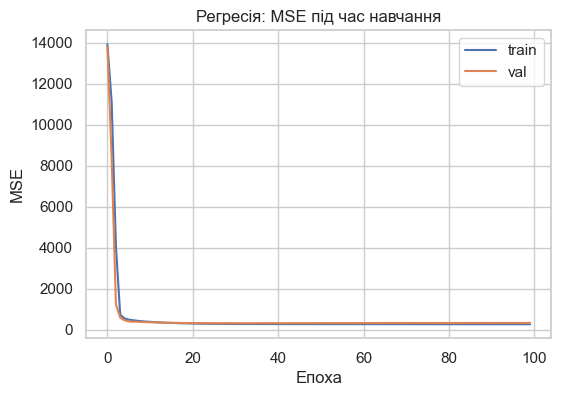

In [4]:
# Побудова моделі регресії
reg_model = Sequential([
    Input(shape=(N_FEATURES,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])
reg_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
reg_model.summary()

# Навчання
history_reg = reg_model.fit(
    Xr_train_s, yr_train,
    epochs=100, batch_size=32,
    validation_split=0.2, verbose=0
)

# Динаміка втрат
plt.figure(figsize=(6,4))
plt.plot(history_reg.history['loss'], label='train')
plt.plot(history_reg.history['val_loss'], label='val')
plt.title('Регресія: MSE під час навчання')
plt.xlabel('Епоха')
plt.ylabel('MSE')
plt.legend()


## 5. Регресія — оцінка якості
Обчислюємо `MSE` та `R²`, будуємо діаграму передбачення vs істинні значення.


MSE: 344.754 R^2: 0.978


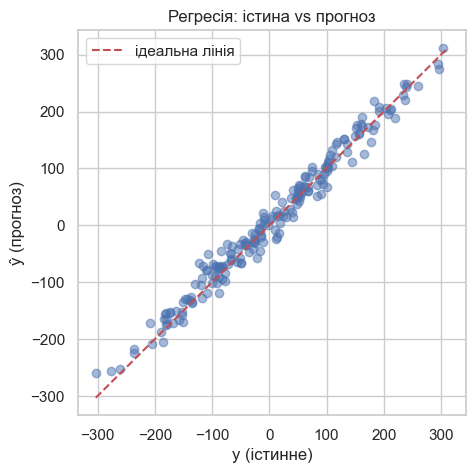

In [5]:
# Оцінка
yr_pred = reg_model.predict(Xr_test_s, verbose=0).ravel()
mse = mean_squared_error(yr_test, yr_pred)
r2 = r2_score(yr_test, yr_pred)
print(f'MSE: {mse:.3f} R^2: {r2:.3f}')

# Візуалізація: істина vs прогноз
plt.figure(figsize=(5,5))
plt.scatter(yr_test, yr_pred, alpha=0.5)
mn, mx = min(yr_test.min(), yr_pred.min()), max(yr_test.max(), yr_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', label='ідеальна лінія')
plt.title('Регресія: істина vs прогноз')
plt.xlabel('y (істинне)')
plt.ylabel('ŷ (прогноз)')
plt.legend()


## 6. Класифікація — підготовка даних
Генеруємо бінарну класифікацію `make_classification` з контрольованою відокремленістю класів `class_sep`.
- Мета: навчити модель передбачати клас `y ∈ {0,1}`.
- Масштабуємо ознаки перед навчанням.


In [6]:
# Генерація даних для класифікації
n_informative = max(2, int(np.ceil(N_FEATURES * 0.6)))
n_redundant = max(0, N_FEATURES - n_informative)
X_clf, y_clf = make_classification(
    n_samples=N_SAMPLES, n_features=N_FEATURES,
    n_informative=n_informative, n_redundant=n_redundant,
    n_clusters_per_class=1, class_sep=class_sep,
    flip_y=0.01, random_state=RANDOM_STATE
)

# Тренувально/тестовий спліт
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_clf
)

# Масштабування ознак
scaler_clf = StandardScaler()
Xc_train_s = scaler_clf.fit_transform(Xc_train)
Xc_test_s  = scaler_clf.transform(Xc_test)

Xc_train_s.shape, Xc_test_s.shape, yc_train.shape, yc_test.shape


((800, 5), (200, 5), (800,), (200,))

## 7. Класифікація — побудова та навчання моделі (Keras)
Архітектура для бінарної класифікації: 
- `Dense(32, relu)` → `Dense(16, relu)` → вихід `Dense(1, activation='sigmoid')`;
- Функція втрат: `binary_crossentropy`, метрика: `accuracy`.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

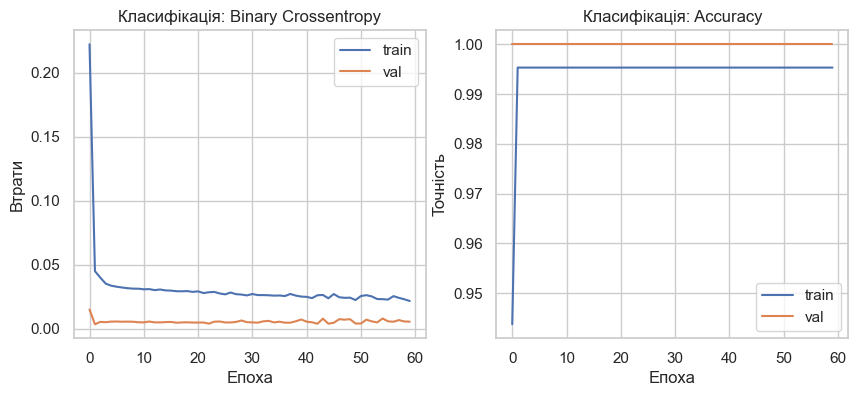

In [7]:
# Побудова моделі класифікації
clf_model = Sequential([
    Input(shape=(N_FEATURES,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
clf_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
clf_model.summary()

history_clf = clf_model.fit(
    Xc_train_s, yc_train,
    epochs=60, batch_size=32,
    validation_split=0.2, verbose=0
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_clf.history['loss'], label='train')
plt.plot(history_clf.history['val_loss'], label='val')
plt.title('Класифікація: Binary Crossentropy')
plt.xlabel('Епоха'); plt.ylabel('Втрати'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history_clf.history['accuracy'], label='train')
plt.plot(history_clf.history['val_accuracy'], label='val')
plt.title('Класифікація: Accuracy')
plt.xlabel('Епоха'); plt.ylabel('Точність'); plt.legend()


## 8. Класифікація — оцінка якості
Обчислюємо точність, будуємо матрицю плутанини, ROC-криву та звіт класифікації.


Accuracy: 0.995 ROC AUC: 0.996


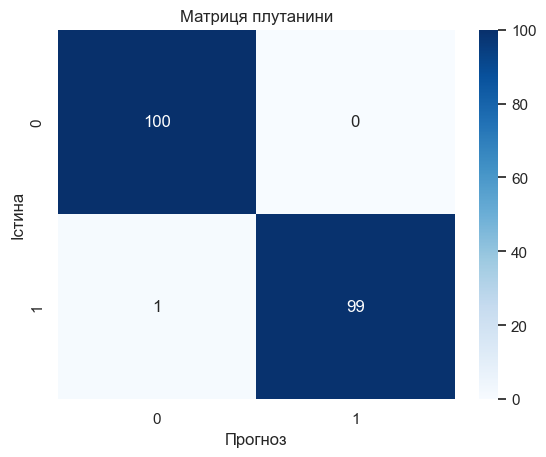

              precision    recall  f1-score   support

           0      0.990     1.000     0.995       100
           1      1.000     0.990     0.995       100

    accuracy                          0.995       200
   macro avg      0.995     0.995     0.995       200
weighted avg      0.995     0.995     0.995       200



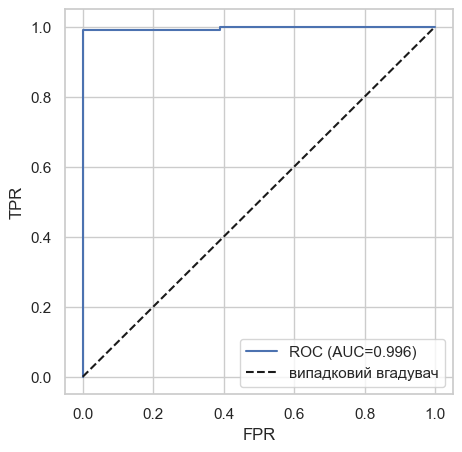

In [8]:
# Ймовірності та класи
yc_proba = clf_model.predict(Xc_test_s, verbose=0).ravel()
yc_pred = (yc_proba >= 0.5).astype(int)

# Базові метрики
acc = accuracy_score(yc_test, yc_pred)
auc = roc_auc_score(yc_test, yc_proba)
print(f'Accuracy: {acc:.3f} ROC AUC: {auc:.3f}')

# Матриця плутанини
cm = confusion_matrix(yc_test, yc_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матриця плутанини')
plt.xlabel('Прогноз'); plt.ylabel('Істина')
plt.show()

# ROC-крива
fpr, tpr, thr = roc_curve(yc_test, yc_proba)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'k--', label='випадковий вгадувач')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()

# Розширений звіт
print(classification_report(yc_test, yc_pred, digits=3))


## 9. Висновки
- Ми виконали повний цикл для двох типів задач: регресія та класифікація.
- Параметри генерації даних і випадкові зерна привʼязані до номера у журналі (**7**), що гарантує відтворюваність.
- Для регресії оцінювали `MSE` і `R²`; для класифікації — `Accuracy`, `ROC AUC`, матрицю плутанини та класифікаційний звіт.
- За бажанням, можна експериментувати з архітектурою мережі, кількістю епох, розміром батча та ступенем регуляризації, фіксуючи при цьому `RANDOM_STATE` для коректного порівняння.
